In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import feather

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import stats

In [2]:
# # Load in the time_series from the previous stage in the pipeline
# correlations = feather.read_dataframe("../data_files/B/once/75days/5mins/best_correlations_5mins_code_hour_day.feather")
# correlations = correlations.set_index(correlations.columns[0])


In [3]:
se = feather.read_dataframe("../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_offsets_noninterp.feather")
se = se.set_index(se.columns[0])

In [4]:
se = se.dropna(subset=['median_durations_by_segment_code_and_hour_and_day'])

In [5]:
# se.iloc[1978]

In [6]:
def filter_rare(stop_events):

    print("Calculating rare segments...")

    segment_counts = stop_events.groupby("segment_code").size()

    filtered_stop_events = stop_events.drop(
        stop_events[
            stop_events["segment_code"].isin(
                segment_counts[segment_counts < 120].index.values
            )
        ].index
    )

    print("\tCalculated")

    return filtered_stop_events

se = filter_rare(se)

Calculating rare segments...
	Calculated


In [7]:
def MAPE(forecast, actual):
    
    if(len(forecast) != len(actual)):
        raise ValueError('Could not calculate MAPE, forecast and actual arrays are different length')
        
    forecast = np.asarray(forecast)
    actual = np.asarray(actual)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        
        division = (actual-forecast)/actual
        
        division[actual == 0] = 0
        
        # Instead of dividing by n we count by the number of non-zero values. 
        # Essentially ignoring all cases where the actual value is zero. 
        mape = 100 / np.count_nonzero(actual) * np.sum(np.abs(division))
    
    return mape

In [8]:
def make_prediction(medians, results):
    return medians * (1 + (results / 100))




### The percentage of all events that have at least one bus in the proceeding five mins

In [9]:
np.count_nonzero(~np.isnan(se['self_offset_5_1']))/len(se['self_offset_5_1'])*100

31.311278498770122

### The percentage of all events that have at least one bus in the proceeding ten mins

In [10]:
(np.count_nonzero(~np.isnan(se['self_offset_5_1']))+np.count_nonzero(~np.isnan(se[np.isnan(se['self_offset_5_1'])]['self_offset_5_2'])))/len(se['self_offset_5_1'])*100

53.56000873104922

### The percentage of all events that have at least one bus in the proceeding fifteen mins

In [11]:
(np.count_nonzero(~np.isnan(se['self_offset_5_1']))+ \
 np.count_nonzero(~np.isnan(se[np.isnan(se['self_offset_5_1'])]['self_offset_5_2'])) + \
 np.count_nonzero(~np.isnan(se[(np.isnan(se['self_offset_5_1'])) & (np.isnan(se['self_offset_5_2']))]['self_offset_5_3'])))/len(se['self_offset_5_1'])*100

69.33178114680545

## Trying different ways to make the previous busses predict the next ones

In [12]:
mask = ~np.isnan(se[se['test']]['self_offset_5_1'])

In [14]:
se['mean_both_sides'] = 0

se.loc[~np.isnan(se['self_offset_5_1']),'mean_both_sides'] = se[~np.isnan(se['self_offset_5_1'])][['self_offset_5_1', 'prev_stop_1_offset_5_1', 'next_stop_1_offset_5_1']].mean(axis=1)

In [15]:
mask = ~np.isnan(se[se['test']]['self_offset_5_1'])

for i in np.linspace(-.5,0.5,21):

    results_rules = np.zeros(se[se['test']].shape[0])
    results_rules = se[se['test']]['mean_both_sides'] * i
    
    results_rules = np.clip(results_rules, -25, 25)
    predict_rules = make_prediction(se[se['test']]['median_durations_by_segment_code_and_hour_and_day'], results_rules)
    
    print(f"i:{i} MAPE:{MAPE(predict_rules, se[se['test']]['segment_duration'])}")

i:-0.5 MAPE:27.110827507708876
i:-0.45 MAPE:27.03377758147797
i:-0.4 MAPE:26.95449424420765
i:-0.35 MAPE:26.873275204698277
i:-0.3 MAPE:26.79083407222017
i:-0.25 MAPE:26.708044741359537
i:-0.19999999999999996 MAPE:26.625735317095447
i:-0.14999999999999997 MAPE:26.547891243260135
i:-0.09999999999999998 MAPE:26.480627299177872
i:-0.04999999999999999 MAPE:26.434317567932904
i:0.0 MAPE:26.428944972108592
i:0.050000000000000044 MAPE:26.511683082581754
i:0.10000000000000009 MAPE:26.607087190139666
i:0.15000000000000002 MAPE:26.70435216875476
i:0.20000000000000007 MAPE:26.79915225521946
i:0.25 MAPE:26.88955456100922
i:0.30000000000000004 MAPE:26.975656639500105
i:0.3500000000000001 MAPE:27.056773647629445
i:0.4 MAPE:27.13305226905069
i:0.45000000000000007 MAPE:27.20515787039868
i:0.5 MAPE:27.272731007191734


In [16]:
for i in np.linspace(0,1.1, 10):

    results_rules = np.zeros(se[se['test']].shape[0])
    results_rules[mask] = se[se['test']][mask]['self_offset_5_1'] * i
    
    results_rules = np.clip(results_rules, -25, 25)
    predict_rules = make_prediction(se[se['test']]['median_durations_by_segment_code_and_hour_and_day'], results_rules)
    
    print(f"i:{i} MAPE:{MAPE(predict_rules, se[se['test']]['segment_duration'])}")

i:0.0 MAPE:26.428944972108592
i:0.12222222222222223 MAPE:26.605798624988633
i:0.24444444444444446 MAPE:26.766327555306077
i:0.3666666666666667 MAPE:26.901031203675103
i:0.48888888888888893 MAPE:27.026755872685317
i:0.6111111111111112 MAPE:27.152973635134412
i:0.7333333333333334 MAPE:27.2763037327777
i:0.8555555555555556 MAPE:27.396142611126653
i:0.9777777777777779 MAPE:27.503690185849905
i:1.1 MAPE:27.614302806374265


In [23]:
for i in np.linspace(-1,1,11):

    results_rules = np.zeros(se[se['test']].shape[0])
    results_rules[mask] = se[se['test']][mask]['mean_both_sides'] * i
    results_rules = np.clip(results_rules, -50, 50)
    predict_rules = make_prediction(se[se['test']]['median_durations_by_segment_code_and_hour_and_day'], results_rules)
    
    print(f"i:{i} MAPE:{MAPE(predict_rules, se[se['test']]['segment_duration'])}")

i:-1.0 MAPE:29.04234816502844
i:-0.8 MAPE:28.517254547740137
i:-0.6 MAPE:27.942299706439552
i:-0.3999999999999999 MAPE:27.33047889288915
i:-0.19999999999999996 MAPE:26.732169650869167
i:0.0 MAPE:26.428944972108592
i:0.20000000000000018 MAPE:26.897050022193092
i:0.40000000000000013 MAPE:27.458909783308016
i:0.6000000000000001 MAPE:27.99176966630747
i:0.8 MAPE:28.482309696369423
i:1.0 MAPE:28.932268299281905


In [24]:
np.count_nonzero(np.isnan(se['median_durations_by_segment_code_and_hour_and_day']))

0

/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


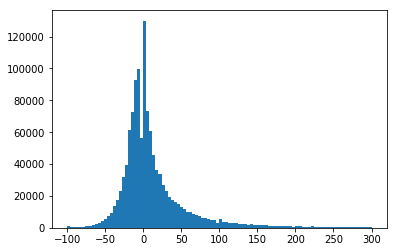

In [25]:
plt.hist(se['self_offset_5_1'], bins=100, range=(-100, 300));

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


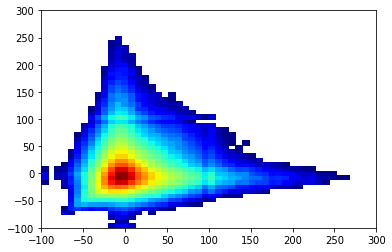

In [26]:
plt.hist2d(se['self_offset_5_1'], se['diff_percent_segment_and_median_by_segment_code_and_hour_and_day'], bins=50, range=[[-100, 300], [-100, 300]], cmin=100, cmap=plt.cm.jet, norm=colors.LogNorm());


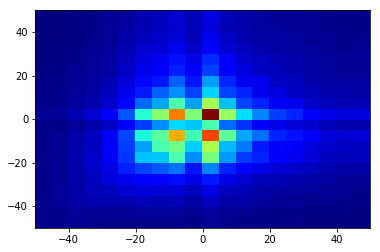

In [27]:
plt.hist2d(np.clip(se['self_offset_5_1'], -100, 100), np.clip(se['diff_percent_segment_and_median_by_segment_code_and_hour_and_day'], -100, 100), bins=20, range=[[-50, 50], [-50, 50]], cmin=100, cmap=plt.cm.jet);

In [28]:
se[se['self_offset_5_1'] > 50]['diff_percent_segment_and_median_by_segment_code_and_hour_and_day'].mean()

45.269426986510226

In [29]:
se[se['self_offset_5_1'] < -50]['diff_percent_segment_and_median_by_segment_code_and_hour_and_day'].mean()

12.163401004491455

In [30]:
np.percentile(se[~np.isnan(se['self_offset_5_1'])]['self_offset_5_1'].values, (5, 95))

array([-33.33333333, 125.97402597])

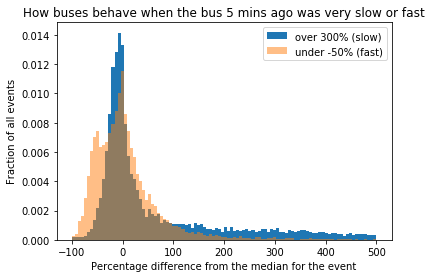

In [31]:
plt.hist(se[se['self_offset_5_1'] > 300]['diff_percent_segment_and_median_by_segment_code_and_hour_and_day'], bins=100, range=(-100, 500), label="over 300% (slow)", density=True);
plt.hist(se[se['self_offset_5_1'] < -50]['diff_percent_segment_and_median_by_segment_code_and_hour_and_day'], bins=100, range=(-100, 500), alpha=0.5, label="under -50% (fast)", density=True);
plt.legend()
plt.xlabel("Percentage difference from the median for the event")
plt.ylabel("Fraction of all events")
plt.title("How buses behave when the bus 5 mins ago was very slow or fast")
plt.savefig("Outliers.png", dpi=500)

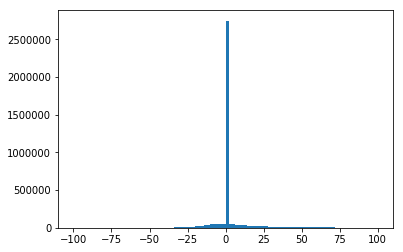

In [32]:
plt.hist(se['mean_both_sides'], bins=100, range=(-100, 100));

In [34]:
se[['diff_percent_segment_and_median_by_segment_code_and_hour_and_day', 'self_offset_5_1', 'self_offset_5_2', 'self_offset_5_3', 'mean_both_sides']].corr()


,diff_percent_segment_and_median_by_segment_code_and_hour_and_day,self_offset_5_1,self_offset_5_2,self_offset_5_3,mean_both_sides
diff_percent_segment_and_median_by_segment_code_and_hour_and_day,1.000000,0.183549,0.154538,0.143330,0.074754
self_offset_5_1,0.183549,1.000000,0.230755,0.195831,0.791027
self_offset_5_2,0.154538,0.230755,1.000000,0.221994,0.124446
self_offset_5_3,0.143330,0.195831,0.221994,1.000000,0.094798
mean_both_sides,0.074754,0.791027,0.124446,0.094798,1.000000


The conclusion is that you really can't use the microscopic to predict the microscopic as the noise it too much!

## Looking at Noise now

Starting by making some more medians to compare

In [37]:
se['dry'] = (se['rain'] == 0)
se['weekend'] = (se['arrival_day'] > 4)

In [38]:
segment_code_and_hour_and_daytype_groups = se[se["train"]].groupby(
    ["segment_code", "arrival_hour", "weekend"]
)

median_durations_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["segment_duration"]
    .median()
    .rename("median_durations_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    median_durations_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [39]:
segment_code_and_hour_and_daytype_dry_groups = se[se["train"]].groupby(
    ["segment_code", "arrival_hour", "weekend", "dry"]
)

median_durations_by_segment_code_and_hour_and_daytype_and_dry = (
    segment_code_and_hour_and_daytype_dry_groups["segment_duration"]
    .median()
    .rename("median_durations_by_segment_code_and_hour_and_daytype_and_dry")
)

se = se.merge(
    median_durations_by_segment_code_and_hour_and_daytype_and_dry.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend", "dry"],
    right_index=True,
)

In [40]:
segment_code_and_hour_and_day_dry_groups = se[(se["train"])].groupby(
    ["segment_code", "arrival_hour", "arrival_day", 'dry']
)

median_durations_by_segment_code_and_hour_and_day_dry = (
    segment_code_and_hour_and_day_dry_groups["segment_duration"]
    .median()
    .rename("median_durations_by_segment_code_and_hour_and_day_dry")
)
se = se.merge(
    median_durations_by_segment_code_and_hour_and_day_dry.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "arrival_day", 'dry'],
    right_index=True,
)

In [42]:
segment_code_and_day_groups = se[(se["train"])].groupby(
    ["segment_code", "arrival_day"]
)

mean_durations_by_segment_code_and_day = (
    segment_code_and_day_groups["segment_duration"]
    .mean()
    .rename("mean_durations_by_segment_code_and_day")
)
se = se.merge(
    mean_durations_by_segment_code_and_day.to_frame(),
    "left",
    left_on=["segment_code", "arrival_day"],
    right_index=True,
)

In [46]:
se['diff_segment_and_mediun_by_segment_code_and_hour_and_daytype'] = se['segment_duration'] - se['median_durations_by_segment_code_and_hour_and_daytype']


Looking at the bayesian esimates of some means and standard deviations

In [47]:
stats.bayes_mvs(se['diff_segment_and_mediun_by_segment_code_and_hour_and_daytype'], alpha=0.9)

(Mean(statistic=6.519246219417394, minmax=(6.490571141811569, 6.54792129702322)),
 Variance(statistic=1190.4587730594515, minmax=(1189.059582778715, 1191.857963340188)),
 Std_dev(statistic=34.50302556384659, minmax=(34.48274922202046, 34.523301905672724)))

In [48]:
stats.bayes_mvs(se['diff_segment_and_median_by_segment_code'], alpha=0.9)

(Mean(statistic=7.718837493984639, minmax=(7.6888147982059065, 7.748860189763371)),
 Variance(statistic=1304.9820172497994, minmax=(1303.4482235591709, 1306.5158109404279)),
 Std_dev(statistic=36.124534837832854, minmax=(36.10330558605821, 36.145764089607496)))

In [49]:
stats.bayes_mvs(se['segment_duration'], alpha=0.9)

(Mean(statistic=46.03824531440074, minmax=(46.000698393453874, 46.075792235347606)),
 Variance(statistic=2041.0507928807974, minmax=(2038.6518703002623, 2043.4497154613325)),
 Std_dev(statistic=45.17799013768538, minmax=(45.15144045527118, 45.204539820099576)))

In [50]:
se['segment_duration'].mean()

46.03824531440074

In [51]:
se['segment_duration'].std()

45.17799590453899

In [52]:
MAPE(se[se['test']]['median_durations_by_segment_code_and_hour_and_day'], se[se['test']]['segment_duration'])

26.428944972108592

In [53]:
MAPE(se[se['test']]['median_durations_by_segment_code_and_hour'], se[se['test']]['segment_duration'])

26.128583183387658

In [54]:
MAPE(se[se['test']]['median_durations_by_segment_code'], se[se['test']]['segment_duration'])

26.66096050180584

In [55]:
mask = (se['test']) & (~np.isnan(se['median_durations_by_segment_code_and_hour_and_day_dry']))

MAPE(se[mask]['median_durations_by_segment_code_and_hour_and_day_dry'], se[mask]['segment_duration'])


27.910705669274943

In [56]:
mask = (se['test']) & (~np.isnan(se['median_durations_by_segment_code_and_hour_and_daytype_and_dry']))

MAPE(se[mask]['median_durations_by_segment_code_and_hour_and_daytype_and_dry'], se[mask]['segment_duration'])



26.22647711420303

In [57]:
MAPE(se[se['test']]['median_durations_by_segment_code_and_hour_and_daytype'], se[se['test']]['segment_duration'])


25.991789218474246

In [58]:
MAPE(se[se['test']]['mean_durations_by_segment_code_and_day'], se[se['test']]['segment_duration'])

38.52029004826241

In [59]:
(se['median_durations_by_segment_code_and_hour_and_daytype'] - se['median_durations_by_segment_code']).std()

9.884577531897612

In [60]:
(se['median_durations_by_segment_code_and_hour_and_daytype'] - se['median_durations_by_segment_code']).abs().mean()

4.141688845318741

Find the mean absolute difference and the standard devations of each pair of buses that do the same segment within 5 mins of each other.

In [61]:
se_segment_name_groups = se.groupby("segment_name")

In [104]:
differences = []
arrival_hours = []
weekend = []
dry = []
length = []
distance = []

for name, segment in se_segment_name_groups:
    
    segment = segment.sort_values("actualArrival")
    
    previous_bus = segment.shift(1)
    
    mask = (segment['actualArrival'] - previous_bus['actualArrival']) < pd.Timedelta("5 minute")
    
    differences.extend(segment[mask]['segment_duration'] - previous_bus[mask]['segment_duration'])
    
    arrival_hours.extend(segment[mask]['arrival_hour'])
    
    weekend.extend(segment[mask]['weekend'])
    
    dry.extend(segment[mask]['dry'])
    
    length.extend(segment[mask]['line_distance'])
    
    distance.extend(segment[mask]['to_centre_dist'])
    

In [105]:
differences = np.array(differences)
arrival_hours = np.array(arrival_hours)
weekend = np.array(weekend)
dry = np.array(dry)
length = np.array(length)
distance = np.array(distance)

In [92]:
length = len(differences)

print(length)

differences_filtered = np.sort(differences)[int(length/100):-int(length/100)]

print(len(differences_filtered))

1162208
1138964


In [64]:
stats.bayes_mvs(differences, alpha=0.9)

(Mean(statistic=-0.5940287797020843, minmax=(-0.6577734855331612, -0.5302840738710075)),
 Variance(statistic=1745.4909021800968, minmax=(1741.7245761318652, 1749.2572282283284)),
 Std_dev(statistic=41.77907253853413, minmax=(41.733998224776236, 41.824146852292024)))

In [73]:
stats.bayes_mvs(differences_filtered, alpha=0.9)

(Mean(statistic=-0.3783763139133458, minmax=(-0.41561192097219857, -0.3411407068544931)),
 Variance(statistic=583.6767053909387, minmax=(582.4044930124313, 584.948917769446)),
 Std_dev(statistic=24.159402008140404, minmax=(24.13307245788749, 24.185731558393318)))

In [75]:
np.mean(np.abs(differences))

18.614040688069604

In [76]:
np.median(np.abs(differences))

8.0

In [120]:
np.mean(np.abs(differences_filtered))

14.820170786785184

In [121]:
np.median(np.abs(differences_filtered))

7.0

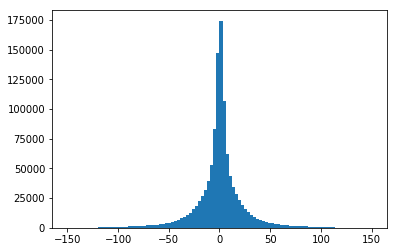

In [78]:
plt.hist(differences_filtered, bins=100, range=(-150, 150));

In [96]:
hour = []
std = []

for i in range(23):
    hour.append(i)
    
    std.append(differences[arrival_hours == i].std())

/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Standard Deviation (sec)')

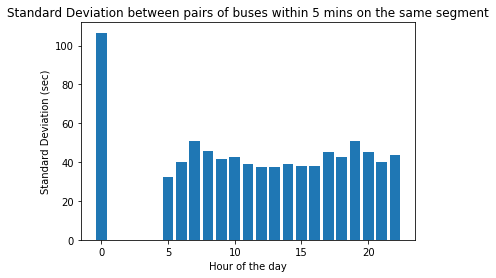

In [99]:
plt.bar(hour, std)
plt.title("Standard Deviation between pairs of buses within 5 mins on the same segment")
plt.xlabel("Hour of the day")
plt.ylabel("Standard Deviation (sec)")

In [106]:
dry_s = []
std = []

for i in range(2):
    dry_s.append(i)
    
    std.append(differences[dry == i].std())

Text(0, 0.5, 'Standard Deviation (sec)')

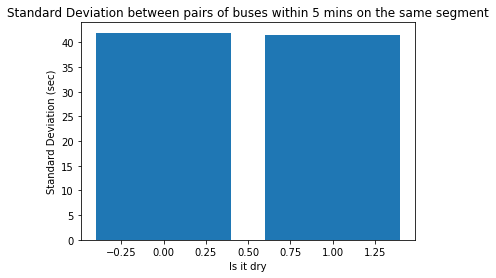

In [107]:
plt.bar(dry_s, std)
plt.title("Standard Deviation between pairs of buses within 5 mins on the same segment")
plt.xlabel("Is it dry")
plt.ylabel("Standard Deviation (sec)")

In [113]:
length_s = []
std = []

for i in np.linspace(0, 1, 11):
    
    length_s.append(i)
    
    std.append(differences[(length > i) & (length < i + 0.1)].std())

/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Standard Deviation (sec)')

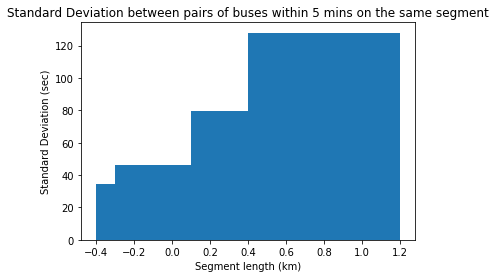

In [114]:
plt.bar(length_s, std)
plt.title("Standard Deviation between pairs of buses within 5 mins on the same segment")
plt.xlabel("Segment length (km)")
plt.ylabel("Standard Deviation (sec)")

In [116]:
distance_s = []
std = []

for i in np.linspace(0, 10, 11):
    
    distance_s.append(i)
    
    std.append(differences[(distance > i) & (distance < i + 1)].std())

Text(0, 0.5, 'Standard Deviation (sec)')

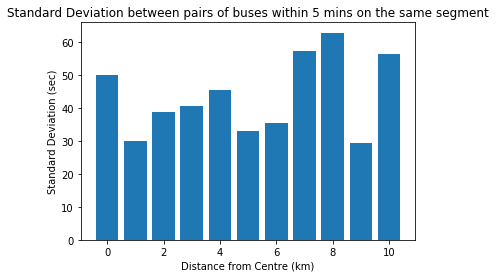

In [119]:
plt.bar(distance_s, std)
plt.title("Standard Deviation between pairs of buses within 5 mins on the same segment")
plt.xlabel("Distance from Centre (km)")
plt.ylabel("Standard Deviation (sec)")